### Contents:
- [Problem Statement](#Data-Sets)
- [Collecting the Data](#Data-Import-and-Cleaning)
- [Evaluating the Data Collected](#Exploratory-Data-Analysis)
- [Visualization](#Visualize-the-Data)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

### Problem Statement

Nate Silver and co. at Fivethirtyeight have agreed to hear my pitch for a story. I have chosen to write a piece on how to create a reddit post that will generate the most user engagement from reddit users. This project explores webscraping and language patterns to help determine popular reddit posts. 

In [ ]:
# Imports
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
import matplotlib.pyplot as plt
import seaborn as sns
from selenium.webdriver.common.by import By
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os
from os.path import exists
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from collections import Counter

###                                                                              Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**subreddit**|*obj*|backup_data.csv|The title of the subreddit|
|**title**|*obj*|backup_data.csv|Title of post|
|**num_comments**|*int*|backup_data.csv|Total number of comments on post|
|**upvotes**|*int*|backup_data.csv|Total number of upvotes on post|
|**created_at**|*int*|backup_data.csv|Epoch time of post creation|
|**high_low_count**|*int*|backup_data.csv|Binary column of upper and lower 75th percentile|
|**title_length**|*int*|backup_data.csv|Total characters of post|
|**title_word_count**|*int*|backup_data.csv|total count of words in title column|


### Collecting the Data

Running the cell block below scrapes data from reddit's front page and adds it to a dataframe. 

In [4]:
# Options needed to run selenium web driver
ser = Service('chromedriver.exe')
op = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=ser, options=op)
driver.get('https://www.reddit.com/')

# list of dictionaries to convert to Dataframe
dict_list = []

# scrolls through page and collects html for entire posts
while len(dict_list) < 500:
        
        
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    for post in soup.findAll('div', {'data-testid': 'post-container'}):
        try:
            data_dict = {}

            # Seperates data into dictionary entries and adds to dict list

            data_dict['titles'] = post.find(True, {'class': '_eYtD2XCVieq6emjKBH3m'}).text
            data_dict['subreddit'] = post.find(True, {'class': '_3ryJoIoycVkA88fy40qNJc'})['href']
            data_dict['time_stamp'] = post.find(True, {'class': '_3jOxDPIQ0KaOWpzvSQo-1s'}).text
            data_dict['comments'] = post.find(True, {'class': 'FHCV02u6Cp2zYL0fhQPsO'}).text
            dict_list.append(data_dict)
            time.sleep(1)

        except:
                pass
dict_df = pd.DataFrame(dict_list)

# opens Dataframe file and concatonates new data

if os.path.exists('data_frame'):
    
    df = pd.read_csv('data_frame', index_col=0)

    new_df = pd.concat([df, dict_df])
    new_df.to_csv('data_frame')
    
driver.close()      

    

### Evaluating the data collected 

With reddit being a fairly popular site I decided to scrape my data roughly once every twenty four hours. The goal here was to collect around 10,000 posts. While I was expecting to have some duplicates I found that most of the data I collected was duplicated. It turns out the hot section of reddit is not replaced nearly as quickly as I originally predicted. Fortunately a colleague was able to provide some data collected via reddit's api. In the future for collecting the data live I would suggest scraping the data over a longer period. But in the end API's are almost always the easier solution. 

In [2]:
# reading in and checking dataframe shape
df = pd.read_csv('data_frame',index_col=0)
df.shape

(8053, 4)

In [3]:
# checking for duplicates 
df.duplicated().sum()

6311

In [4]:
# reading in api data
api_df = pd.read_csv('backup_data.csv')
api_df

,id,title,subreddit,num_comments,upvotes,created_at,time_now,time_delta
0,rn8kvc,Probably the smoothest finesse of 2021!,BlackPeopleTwitter,311,11578,1.640303e+09,2021-12-24 02:28:09.360369,0 days 02:48:18.360372
1,rn6oz3,"Since you guys liked my last drawing, here are...",aww,266,29482,1.640297e+09,2021-12-24 02:28:09.360377,0 days 04:18:44.360377
2,rn5ris,ham sniffer,comedyheaven,582,34723,1.640295e+09,2021-12-24 02:28:09.360380,0 days 05:03:01.360380
3,rn7ymz,"Went to Walmart today, first time going anywhe...",MadeMeSmile,197,10692,1.640301e+09,2021-12-24 02:28:09.360382,0 days 03:18:59.360382
4,rn7ny6,Best friend ever?,rareinsults,138,13166,1.640300e+09,2021-12-24 02:28:09.360405,0 days 03:33:10.360405
...,...,...,...,...,...,...,...,...
14908,rmj1fs,Merry Xmas I'm still drinking to the stonk,Superstonk,20,105,1.640220e+09,2021-12-23 02:34:29.649245,0 days 02:00:01.649245
14909,rme83p,Day 10 of Running 7.41 Until MOASS,Superstonk,13,210,1.640206e+09,2021-12-23 02:34:29.649247,0 days 05:55:44.649248
14910,rmkbtk,I'm going to tell my grandchildren this was 2:...,Superstonk,7,75,1.640224e+09,2021-12-23 02:34:29.649250,0 days 00:52:23.649250
14911,rm4wvx,"The Daily Stonk! December 22, 2021. To the SHF...",Superstonk,39,857,1.640178e+09,2021-12-23 02:34:29.649252,0 days 13:26:15.649252


In [5]:
#checking for missing data
api_df.isnull().sum()

id              0
title           0
subreddit       0
num_comments    0
upvotes         0
created_at      0
time_now        0
time_delta      0
dtype: int64

In [6]:
#checking mean, median and mode
api_df.describe()

,num_comments,upvotes,created_at
count,14913.000000,14913.000000,1.491300e+04
mean,120.268625,2244.717830,1.640237e+09
std,453.419705,5863.299155,4.612752e+04
min,0.000000,68.000000,1.640141e+09
25%,14.000000,330.000000,1.640195e+09
50%,33.000000,708.000000,1.640232e+09
75%,89.000000,1770.000000,1.640281e+09
max,18338.000000,143953.000000,1.640311e+09


Since I am trying to predict higher engagement I am making a binary column based off the 75th percentile number of columns with a one being higher or equal to 89 comments and 0 if below. 

In [7]:
# creates new column for 75th percentile of num_comments
api_df['high_low_count'] = np.where(api_df['num_comments'] >= 89, 1, 0)
api_df.head()

,id,title,subreddit,num_comments,upvotes,created_at,time_now,time_delta,high_low_count
0,rn8kvc,Probably the smoothest finesse of 2021!,BlackPeopleTwitter,311,11578,1.640303e+09,2021-12-24 02:28:09.360369,0 days 02:48:18.360372,1
1,rn6oz3,"Since you guys liked my last drawing, here are...",aww,266,29482,1.640297e+09,2021-12-24 02:28:09.360377,0 days 04:18:44.360377,1
2,rn5ris,ham sniffer,comedyheaven,582,34723,1.640295e+09,2021-12-24 02:28:09.360380,0 days 05:03:01.360380,1
3,rn7ymz,"Went to Walmart today, first time going anywhe...",MadeMeSmile,197,10692,1.640301e+09,2021-12-24 02:28:09.360382,0 days 03:18:59.360382,1
4,rn7ny6,Best friend ever?,rareinsults,138,13166,1.640300e+09,2021-12-24 02:28:09.360405,0 days 03:33:10.360405,1


In [8]:
# creates column title length to display amount of characters in title
api_df['title_length'] = [len(letter) for letter in api_df['title']]
# creates column title word count to display words in title 
api_df['title_word_count'] = [len(word.split()) for word in api_df['title'].tolist()]
api_df.head()

,id,title,subreddit,num_comments,upvotes,created_at,time_now,time_delta,high_low_count,title_length,title_word_count
0,rn8kvc,Probably the smoothest finesse of 2021!,BlackPeopleTwitter,311,11578,1.640303e+09,2021-12-24 02:28:09.360369,0 days 02:48:18.360372,1,39,6
1,rn6oz3,"Since you guys liked my last drawing, here are...",aww,266,29482,1.640297e+09,2021-12-24 02:28:09.360377,0 days 04:18:44.360377,1,83,15
2,rn5ris,ham sniffer,comedyheaven,582,34723,1.640295e+09,2021-12-24 02:28:09.360380,0 days 05:03:01.360380,1,11,2
3,rn7ymz,"Went to Walmart today, first time going anywhe...",MadeMeSmile,197,10692,1.640301e+09,2021-12-24 02:28:09.360382,0 days 03:18:59.360382,1,130,21
4,rn7ny6,Best friend ever?,rareinsults,138,13166,1.640300e+09,2021-12-24 02:28:09.360405,0 days 03:33:10.360405,1,17,3


When it comes to title length the average seems to stay around ten words. The higher commented posts seem to have just around two more words in the title. 

In [9]:
#checking average length of titles
api_df['title_word_count'].mean()

9.648561657614161

In [10]:
#checking average length of high posts
api_df['title_word_count'][api_df['high_low_count'] == 1].mean()

11.508379888268156

In [11]:
#checking average length of low posts
api_df['title_word_count'][api_df['high_low_count'] == 0].mean()

9.021785906401291

### Visualization

Looking at the distribution of comments both high and low commented posts are skewed to the right. With our higher posts having outliers around 18 and 17 thousand, and our lower posts staying in a tight pattern and cutting off at around 90 comments.  

In [12]:
#charting distribution of comments above and below 75th percentile
high = api_df[api_df['high_low_count']==1]['num_comments']
low = api_df[api_df['high_low_count']==0]['num_comments']


(0.0, 1000.0)

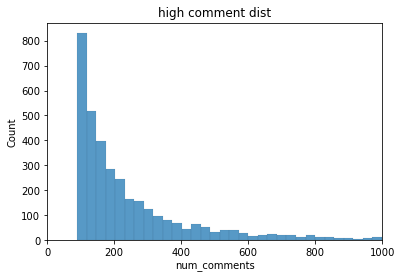

In [13]:
# plots distribution of higher comments 
sns.histplot(high).set_title('high comment dist')
plt.xlim(0, 1000)
#plt.savefig('High comment dist.jpeg')

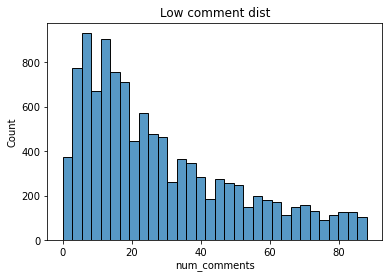

In [14]:
# plots distribution of lower commented comments 
sns.histplot(low).set_title('Low comment dist');
#plt.savefig('Low comment dist.jpeg')

In the cells below I wanted to check what subreddit's were receiving the most and least comments. Askreddit appears the most in my top 10 most interacted with posts. This makes sense as it's a broad subreddit that often gets made into youtube videos which gives it an extra layer of exposure.  For my lowest interacted with posts I'm mostly seeing posts revolving around pictures and videos of people or animals. They don't seem to be receiving many comments as there is nothing to respond to. 

In [15]:
#checking top 10 most commented posts
api_df.nlargest(10,"num_comments")

,id,title,subreddit,num_comments,upvotes,created_at,time_now,time_delta,high_low_count,title_length,title_word_count
7964,rm3qcl,[Serious] [NSFW] What's something that a frien...,AskReddit,18338,50069,1.640174e+09,2021-12-23 02:32:35.511768,0 days 14:36:06.511769,1,153,27
7708,rm9yvr,GIVEAWAY: I'm giving away Escape From Tarkov: ...,EscapefromTarkov,17118,4105,1.640194e+09,2021-12-23 02:32:31.564742,0 days 09:11:15.564742,1,115,20
4680,rmm1la,What is a dark secret that you have ?,AskReddit,14525,28016,1.640229e+09,2021-12-24 02:29:31.176004,0 days 23:17:34.176004,1,37,9
5389,rmv0hz,What was your Christmas bonus?,antiwork,12055,17858,1.640264e+09,2021-12-24 02:29:43.316600,0 days 13:39:47.316600,1,30,5
11285,rm057o,Hawkeye S01E06 (Season Finale) - Discussion Th...,marvelstudios,12016,6545,1.640159e+09,2021-12-23 02:33:32.421153,0 days 18:47:53.421153,1,50,7
118,rmx8t2,What movie do you HAVE to finish watching anyt...,AskReddit,11649,25822,1.640271e+09,2021-12-24 02:28:10.966173,0 days 11:38:19.966174,1,94,16
613,rn3ln1,GIVEAWAY: I'm giving away a $100 Blizzard Bala...,wow,9640,976,1.640289e+09,2021-12-24 02:28:20.577428,0 days 06:45:03.577428,1,89,16
8583,rm3n14,What's something that is unnecessarily expensive?,AskReddit,9109,13758,1.640174e+09,2021-12-23 02:32:46.069069,0 days 14:42:15.069069,1,49,6
7565,rmb4qh,names? shes a girl,teenagers,6907,40109,1.640197e+09,2021-12-23 02:32:27.489934,0 days 08:18:34.489934,1,18,4
9415,rm43yz,"Statue in my home town made of 100,000 knives ...",pics,6760,66218,1.640176e+09,2021-12-23 02:33:01.043198,0 days 14:13:01.043198,1,69,13


In [16]:
#checking least commented posts
api_df.nsmallest(10, "num_comments")

,id,title,subreddit,num_comments,upvotes,created_at,time_now,time_delta,high_low_count,title_length,title_word_count
1110,rn5fiz,This is an amazing idea!,UnexpectedlyWholesome,0,435,1.640294e+09,2021-12-24 02:28:29.181435,0 days 05:18:39.181435,0,24,5
1783,rn1e7v,Tiny blop!,blop,0,493,1.640283e+09,2021-12-24 02:28:39.751822,0 days 08:26:56.751822,0,10,2
2247,rn6eow,Zero x Kallen,CodeGeass,0,192,1.640297e+09,2021-12-24 02:28:48.240654,0 days 04:32:41.240654,0,13,3
2460,rn34sj,‘Can You Check The Back For 500 Million More O...,TheOnion,0,273,1.640287e+09,2021-12-24 02:28:51.737682,0 days 07:07:16.737682,0,113,22
2695,rn6ule,Installing the latest version on the old computer,C_AT,0,148,1.640298e+09,2021-12-24 02:28:55.346665,0 days 04:12:21.346665,0,49,8
2705,rmyidq,Brooke Monk,BrookeMonk,0,477,1.640275e+09,2021-12-24 02:28:57.105236,0 days 10:38:35.105236,0,11,2
2996,rmyh5i,Nap times are the best times,BabyCorgis,0,433,1.640275e+09,2021-12-24 02:29:00.320806,0 days 10:40:18.320807,0,28,6
3087,rn4wlj,I turned my boyfriend's void with eyes in to a...,minimalcatart,0,166,1.640292e+09,2021-12-24 02:29:02.151213,0 days 05:43:34.151213,0,62,13
3107,rn7elj,211114 - Pretty Tzuyu,tzuyu,0,116,1.640299e+09,2021-12-24 02:29:03.790149,0 days 03:46:37.790149,0,21,4
3123,rn7yti,He looks like a mini grandpa! Adorable.!,HeckThisIsWholesome,0,106,1.640301e+09,2021-12-24 02:29:03.790185,0 days 03:19:37.790186,0,40,7


In [17]:
#replaces apostrophes 
api_df['title'] = api_df['title'].apply(lambda x: x.strip().replace("'", ''))
api_df['subreddit'] = api_df['subreddit'].apply(lambda x: x.strip().replace("'", ''))

Now it's time to count vectorize our titles and look for the most popular words. We can also take words we think may be popular and engineer some new features to see if they help our models. For this analysis I will be removing stop words. I've also removed apostrophes from the title column as they will cause auxilary verbs to be counted as seperate words. 

In [18]:
# count vectorizing title column
title_count = api_df['title']

cvec = CountVectorizer(stop_words='english')
cvec.fit(title_count)
word_count = cvec.transform(title_count)
count_df = pd.DataFrame(word_count.todense(), columns=cvec.get_feature_names())

#concatonates vectorized dataframe with api_df
count_df_master = pd.concat([count_df, api_df], axis=1)

In [19]:
#columns to be dropped while doing eda and charting 
drop_col = ['title', 'subreddit', 'num_comments', 'upvotes',
            'created_at', 'time_now', 'time_delta',
            'high_low_count', 'title_length', 'title_word_count', 'id']

# creates variable for top 20 most used words in 75th percentile
high_chart = (count_df_master[count_df_master['high_low_count'] == 1]
              .drop(columns=drop_col)
              .sum()
              .sort_values(ascending=False)
              .head(20))

# creates variable for top 20 most used words below 75th percentile
low_chart = (count_df_master[count_df_master['high_low_count'] == 0]
            .drop(columns=drop_col)
            .sum()
             .sort_values(ascending=False)
            .head(20))

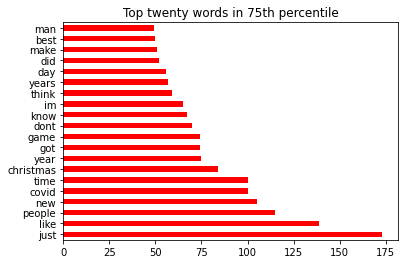

In [20]:
# charts popular words in 75th percentile
high_chart.plot(kind='barh', title="Top twenty words in 75th percentile", color='red');

#plt.savefig('High Top twenty words')

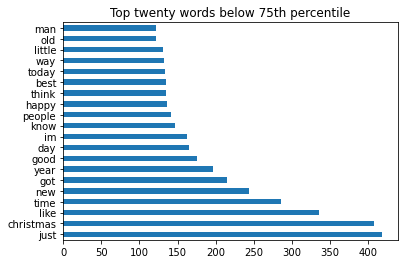

In [21]:
#charts words below 75th percentile 
low_chart.plot(kind='barh', title="Top twenty words below 75th percentile");

#plt.savefig('Low Top twenty words')

From the charts posted above we can see that that both our high and low posts share a decent amount of words with 2 out of the top three words matching. As most of this data was collected towards the hollidays we need to remember that the word Christmas is most likely only going to be this important for this time of year. As for the words just and like we could infer that people are most likely going to be posting about things that they like, or things that may have just happened and spurred a moment of excitement. 

### Creating base models

Now that we have count vectorized the titles column and we have our binary column that dictates whether or not a post is above or below the 75th percentile we can start building some models. I'm going to start off with logistic regression and a random forest classifier. Our base model accuracy is roughly 75% so we need to make a model that can beat that.

In [22]:
# baseline model
1 - api_df['high_low_count'].mean()

0.747938040635687

In [23]:


# columns to drop for our models 
drop_col_m = ['title', 'subreddit',
             'time_now', 'time_delta',
            'high_low_count', 'id']

# setting up X and y variables
X = count_df_master.drop(columns= drop_col_m)
y = api_df['high_low_count']



# Instantiating logistic regression
logreg = LogisticRegression(solver='liblinear')




# setting cross_val_score
scores = cross_val_score(logreg,
                         X,
                         y,
                         cv=KFold(n_splits=5,
                                  shuffle=True,
                                  random_state=73))



In [24]:
# shows accuracy score
print("LogReg score", round(scores.mean(), 2), '+-', round(2 * scores.std(), 2))

LogReg score 0.75 +- 0.01


In [25]:
# Instantiate our Random Forest model 
rf = RandomForestClassifier(class_weight='balanced', 
                            n_estimators=100,            
                            n_jobs=-1)





# setting cross_val_score
scores = cross_val_score(rf,
                         X,
                         y,
                         cv=KFold(n_splits=5,
                                  shuffle=True,
                                  random_state=73))



In [26]:
#shows accuracy score
print("Random Forest score", round(scores.mean(), 2), '+-', round(2 * scores.std(), 2))

Random Forest score 1.0 +- 0.0


By the scores above we can see that Logistic Regression is just ever so slightly better than our null model. While our tree model is showing 100 percent accuracy which is a sign of overfitting.  Next to improve our models we can start removing some features to attempt to remove some of the noise. Let's see how we do if we just count vectorize the individual subreddit's themselves. 

In [27]:
# count vectorizing title column
subreddit_count = api_df['subreddit']

cvec = CountVectorizer(stop_words='english')
cvec.fit(subreddit_count)
word_count = cvec.transform(subreddit_count)
subreddit_count_df = pd.DataFrame(word_count.todense(), columns=cvec.get_feature_names())

#concatonates vectorized dataframe with api_df
count_df_subreddit = pd.concat([subreddit_count_df, api_df], axis=1)

In [28]:
# Creating X variable for subreddit's
X = count_df_subreddit.drop(columns=drop_col_m)



# score and kfold                 
scores = cross_val_score(logreg,
                         X,
                         y,
                         cv=KFold(n_splits=5,
                                  shuffle=True,
                                  random_state=73))
# prints accuracy score
print("LogReg score", round(scores.mean(), 2), '+-', round(2 * scores.std(), 2))


# score and kfold
scores = cross_val_score(rf,
                         X,
                         y,
                         cv=KFold(n_splits=5,
                                  shuffle=True,
                                  random_state=73))
# prints accuracy score 
print("Random Forest score", round(scores.mean(), 2), '+-', round(2 * scores.std(), 2))



LogReg score 0.75 +- 0.01
Random Forest score 1.0 +- 0.0


In [29]:
count_df_master.shape

(14913, 19505)

In [30]:
count_df_subreddit.shape

(14913, 2856)

Now that we've count vectorized our subreddit column we should check in on our most popular subreddit's. It looks like our top three subreddit's are memes, politics, and antiwork. I'm very surprised to not see AskReddit on either list below. 

In [31]:
# shows list of subreddit's in higher commented
(count_df_subreddit[count_df_subreddit['high_low_count'] == 1]
              .drop(columns=drop_col)
              .sum()
              .sort_values(ascending=False)
              .head(20))

memes                    64
politics                 56
antiwork                 55
politicalcompassmemes    51
superstonk               48
cringetopia              44
nba                      39
teenagers                35
facepalm                 33
formula1                 32
hermancainaward          31
halo                     31
nextfuckinglevel         29
holup                    29
interestingasfuck        29
fantasyfootball          27
publicfreakout           26
conspiracy               26
news                     26
unexpected               25
dtype: int64

In [32]:
# shows top subreddit's in lower commented
(count_df_subreddit[count_df_subreddit['high_low_count'] == 0]
              .drop(columns=drop_col)
              .sum()
              .sort_values(ascending=False)
              .head(20))

superstonk            380
memes                 302
hololive              103
whitepeopletwitter    100
dankmemes              95
holup                  88
tumblr                 86
mademesmile            83
antiwork               81
aww                    79
curatedtumblr          74
interestingasfuck      70
greentext              67
dndmemes               58
genshin_impact         54
nextfuckinglevel       52
gme                    50
cursedcomments         49
formuladank            48
whenthe                47
dtype: int64

Even by eliminating 16,649 features we are getting similar results to our first two models. With logistic regression staying at around 75 percent accuracy. These results make sense as random forests are very prone to overfitting, and logistic regression has a default penalty of "l1" for LASSO. Lasso simply put tries to remove redundant features. Given more time I would like to locate fewer and more meaningful features to hopefully combat the overfitting on my random forest models. 

In [33]:
count_df_master.shape

(14913, 19505)

In [34]:
api_df.shape

(14913, 11)

# Conclusion and Recommendations 

To answer our problem statement I would say based off of my EDA we would want to select either AskReddit or memes as our subreddit to launch our post.  The post itself based off of the popular words we collected could be something like “people of (blank) what is something you just can’t live without” for example. In the future to further improve upon this project there are a multitude of angles I would like to explore. We could perform sentinment analysis on the titles column to see if titles with more positive or negative words receive more interaction. We could also engineer more topic centered features such as binary columns for celebrities or pets.  

# Executive Summary

In today's society internet presence and knowledge is key. Business's need to be taking advantage of all the free information and advertisement the internet provides. So let's have a look at how this project has accomplished this. We first started off by finding the limitations of webscraping and the convenience of using API's. This let's us know that in the future if we have a timed data collection goal to meet we should be pulling from the data already available using an API if possible. We then evaluated the number of comments that are in our top 10 commented posts and discovered that AskReddit and the word GIVEAWAY gave us significantly  higher comments than other subreddit's. This gives us a good idea that AskReddit, and the word GIVEAWAY do have the potential to produce some high impact results. We now know that our top three most used words are "just", "like", and "people" in our more popular posts. Lastly through modeling we have found that we can have 75 percent confidence in writing a popular post just by using the subreddit's themselves. 
